# **FULL DATASET BINARY**

### **Preliminary steps**

In [1]:
import os 
print(os.getcwd())
#os.chdir('../..')
print(os.getcwd())

/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp
/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp


In [2]:
### PACKAGES
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap
from sklearn.naive_bayes import MultinomialNB

In [3]:
### FUNCTIONS
from src.libs.preprocess_dataframe_train_test import load_all_datasets
from src.pipeline.whole_pipeline import punctuation_map_dimensions_to_names, punctuation_transform, punctuation_map_dimensions_to_names, fit_tfidf_embedding, transform_with_tfidf, train_fine_tune_RF, eval_model, evaluate

In [9]:
### LOAD DATA

data = load_all_datasets()

### Global X, y
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

### Global dataframes
df_train = data["df_train"]
df_test = data["df_test"]

### By type: poetry, essay, story (train)
df_train_poetry = data["df_train_poetry"]
df_train_essay = data["df_train_essay"]
df_train_story = data["df_train_story"]
X_train_poetry = data["X_train_poetry"]
y_train_poetry = data["y_train_poetry"]
X_train_essay = data["X_train_essay"]
y_train_essay = data["y_train_essay"]
X_train_story = data["X_train_story"]
y_train_story = data["y_train_story"]
### By type: poetry, essay, story (test)
df_test_poetry = data["df_test_poetry"]
df_test_essay = data["df_test_essay"]
df_test_story = data["df_test_story"]
X_test_poetry = data["X_test_poetry"]
y_test_poetry = data["y_test_poetry"]
X_test_essay = data["X_test_essay"]
y_test_essay = data["y_test_essay"]
X_test_story = data["X_test_story"]
y_test_story = data["y_test_story"]

Time taken to load dataset: 0.027297019958496094 seconds
Time taken to load dataset: 0.008031129837036133 seconds
Time taken to load dataset: 0.28711390495300293 seconds
Time taken to load dataset: 0.009452104568481445 seconds
Time taken to load dataset: 0.007745027542114258 seconds
Time taken to load dataset: 0.08504700660705566 seconds
Time taken to load dataset: 0.008296966552734375 seconds
Time taken to load dataset: 0.009285688400268555 seconds
Time taken to load dataset: 0.012181997299194336 seconds


## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [10]:
### EMBEDDING

X_train_punct = punctuation_transform(X_train)
X_test_punct = punctuation_transform(X_test)
X_test_poetry_punct = punctuation_transform(X_test_poetry)
X_test_essay_punct = punctuation_transform(X_test_essay)
X_test_story_punct = punctuation_transform(X_test_story)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}


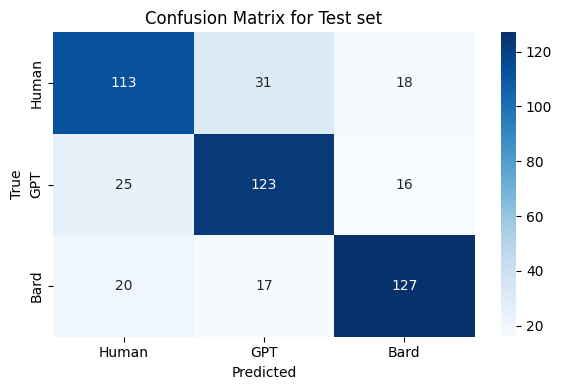

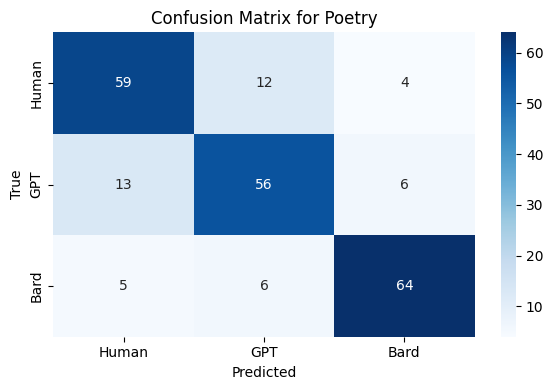

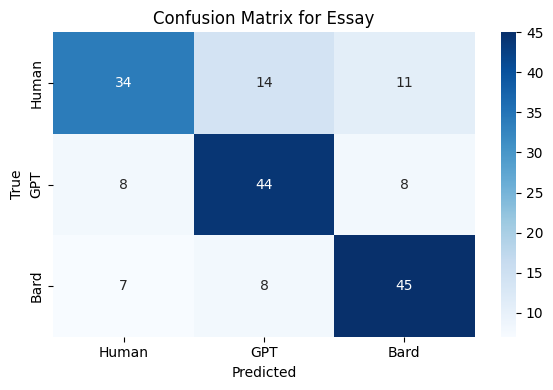

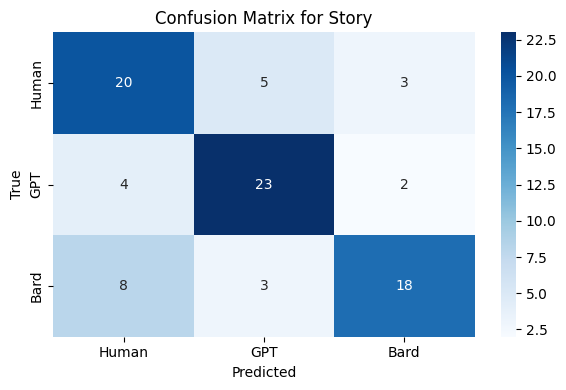

                                     confusion_matrix precision    recall  \
test    [[113, 31, 18], [25, 123, 16], [20, 17, 127]]  0.741103   0.74064   
poetry         [[59, 12, 4], [13, 56, 6], [5, 6, 64]]  0.795952  0.795556   
essay          [[34, 14, 11], [8, 44, 8], [7, 8, 45]]   0.68789  0.686535   
story            [[20, 5, 3], [4, 23, 2], [8, 3, 18]]  0.716515   0.70936   

              f1  
test    0.740706  
poetry  0.795685  
essay   0.684616  
story   0.708547  


RandomForestClassifier(bootstrap=False, max_depth=14, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=239, n_jobs=-1,
                       random_state=42)

In [11]:
### CLASSIFIER


classifier_punct = train_fine_tune_RF(X_train_punct, y_train)
eval_model(classifier_punct, X_train_punct, y_train, X_test_punct, y_test, X_test_poetry_punct, y_test_poetry, X_test_essay_punct, y_test_essay, X_test_story_punct, y_test_story)

In [12]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = punctuation_map_dimensions_to_names()
feature_importances_211 = classifier_punct.feature_importances_

most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]

for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")


ratio_words_per_sentence: 0.3685239713005782
ratio_odd_characters: 0.3359414112689855
ratio_punctuations: 0.29553461743043635


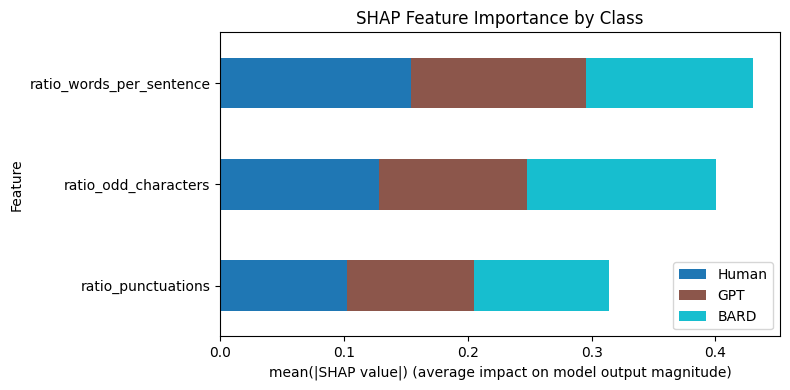

In [13]:
### INTERPRETABILITY - SHAP VALUES
### INTERPRETABILITY - SHAP VALUES

explainer = shap.Explainer(classifier_punct)
X_train_dense = X_train_punct
shap_values = explainer(X_train_dense)
mean_abs_shap_values = np.mean(np.abs(shap_values.values), axis=2)

class_names = ["Human", "GPT", "BARD"]

mean_abs_shap_per_class = np.mean(np.abs(shap_values.values), axis=0)  # shape (n_features, n_classes)

df_shap = pd.DataFrame(mean_abs_shap_per_class, columns=class_names)
df_shap["Feature"] = dim_names_211
df_shap["Total"] = df_shap[class_names].sum(axis=1)
df_shap = df_shap.sort_values("Total").drop(columns="Total")

df_shap.set_index("Feature").plot(kind="barh", stacked=True, figsize=(8, 4), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("SHAP Feature Importance by Class")
plt.tight_layout()
plt.show()

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [14]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


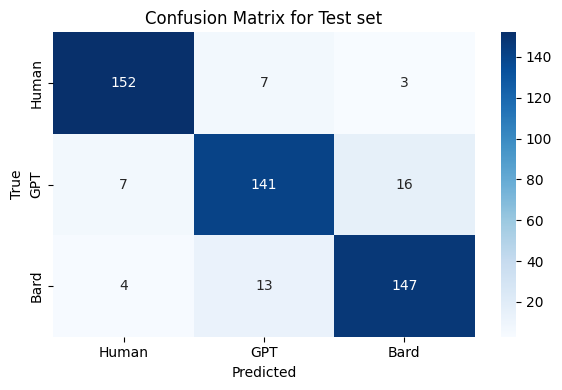

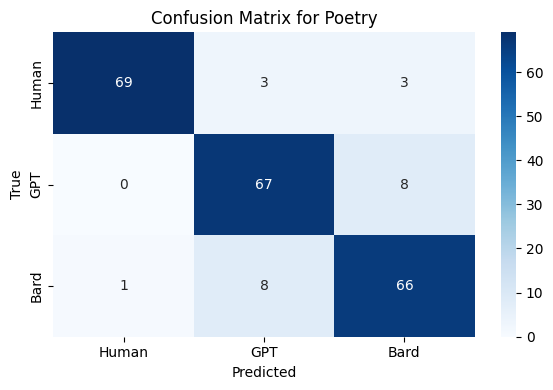

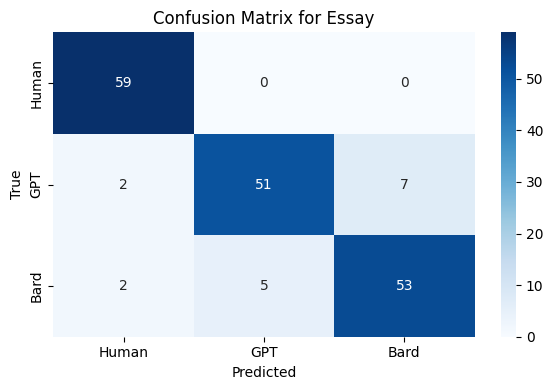

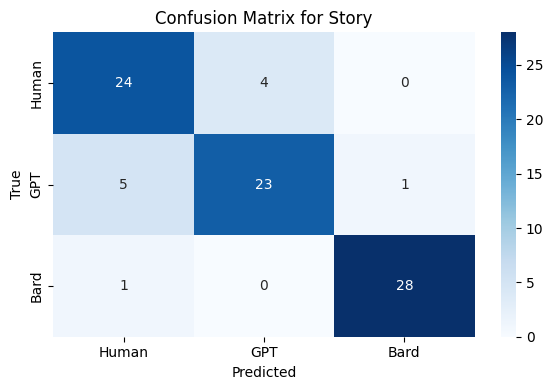

                                 confusion_matrix precision    recall  \
test    [[152, 7, 3], [7, 141, 16], [4, 13, 147]]  0.897945  0.898123   
poetry       [[69, 3, 3], [0, 67, 8], [1, 8, 66]]  0.900611  0.897778   
essay        [[59, 0, 0], [2, 51, 7], [2, 5, 53]]  0.910185  0.911111   
story        [[24, 4, 0], [5, 23, 1], [1, 0, 28]]  0.872456  0.871921   

              f1  
test    0.897995  
poetry  0.898654  
essay   0.909952  
story   0.871511  


RandomForestClassifier(max_depth=18, n_estimators=173, n_jobs=-1,
                       random_state=42)

In [15]:
classifier_tfidf = train_fine_tune_RF(X_train_tfidf, y_train)
eval_model(classifier_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, X_test_poetry_tfidf, y_test_poetry, X_test_essay_tfidf, y_test_essay, X_test_story_tfidf, y_test_story)

In [16]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_tfidf = vectorizer_tfidf.get_feature_names_out()
feature_importances_tfidf = classifier_tfidf.feature_importances_
most_important_features_tfidf = np.argsort(feature_importances_tfidf)[-20:][::-1]
for i in most_important_features_tfidf:
    print(f"{dim_names_tfidf[i]}: {feature_importances_tfidf[i]:.5f}")


really: 0.01898
just: 0.01815
like: 0.01688
help: 0.01641
think: 0.01549
oh: 0.01338
world: 0.01317
believe: 0.01226
reminder: 0.01201
hope: 0.01201
don: 0.01112
heart: 0.01111
make: 0.00882
room: 0.00848
going: 0.00765
conclusion: 0.00732
got: 0.00705
mother: 0.00680
specific: 0.00658
gift: 0.00643


## **BARD**

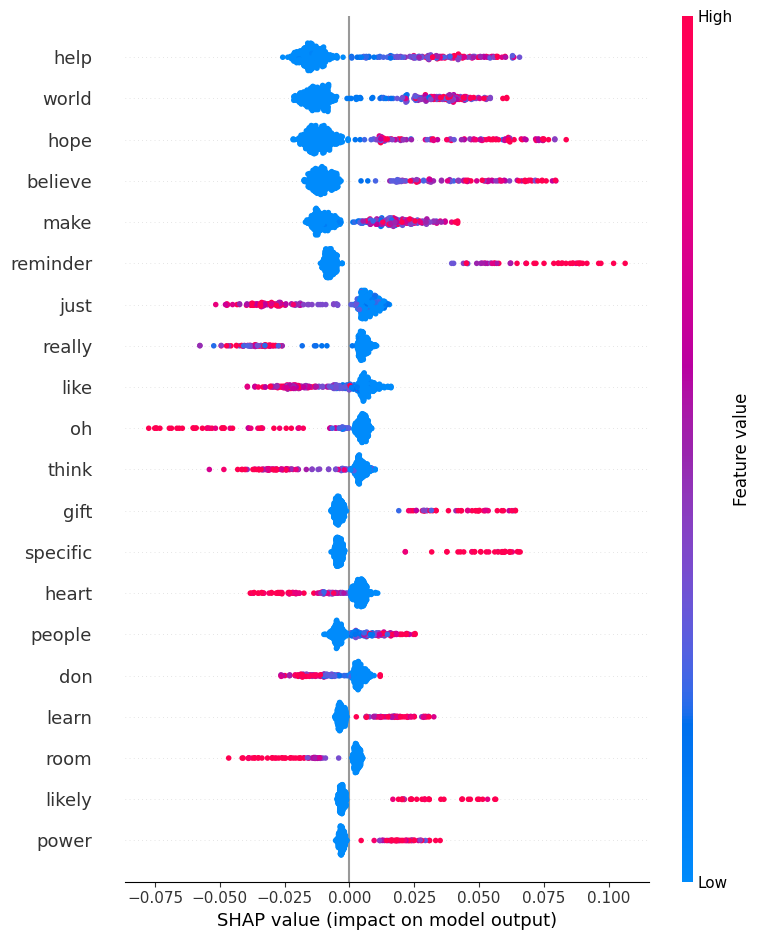

In [22]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(classifier_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,2],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)

## **GPT**

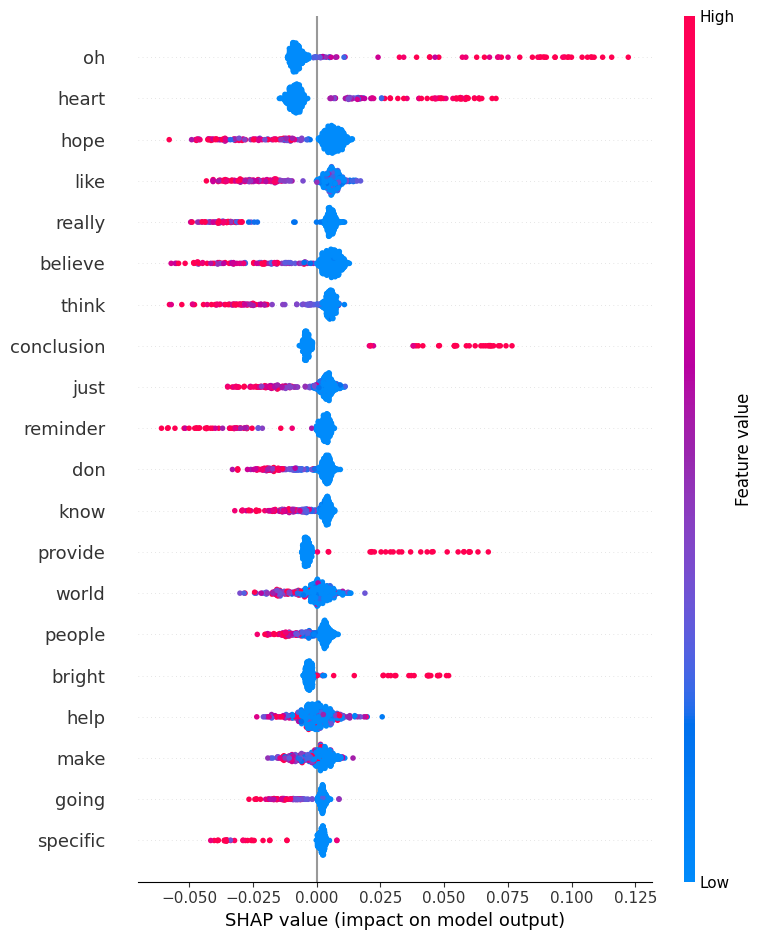

In [23]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(classifier_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,1],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)

## **HUMAN**

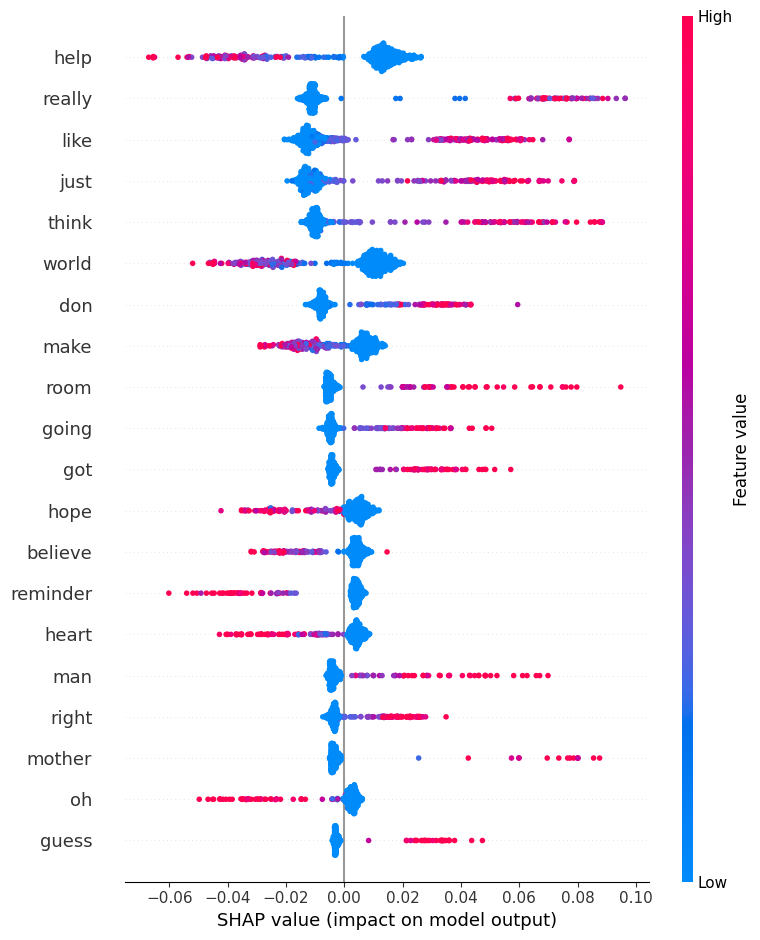

In [24]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(classifier_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,0],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)